In [8]:
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from entsoe2 import fetch_entsoe_data
from n_trim import drop_buses
from zones import assign_zones
import os

1. Importing nordic grid from pypsa eur ex DC links to non-nordic countries

In [9]:
n = pypsa.Network("base_s_65_elec_.nc")

<frozen importlib._bootstrap>:488: RuntimeWarning:

numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject

INFO:pypsa.network.io:New version 1.0.2 available! (Current: 0.35.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, lines, links, loads, storage_units, stores


2. Assign zone column to loads, generators, storage units and buses

In [10]:
n = assign_zones(n)
n.buses.head()

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,country,substation_lv,substation_off,zone
Bus,,,,,,,,,,,,,,,,,
DK0 0,380.0,,9.727929,56.142471,AC,,,1.0,0.0,inf,Slack,,,DK,1.0,1.0,DK_1
DK1 0,380.0,,12.303316,55.515974,AC,,,1.0,0.0,inf,Slack,,,DK,1.0,1.0,DK_2
FI1 0,380.0,,21.920495,61.332573,AC,,,1.0,0.0,inf,PQ,,,FI,1.0,1.0,FI
FI1 1,380.0,,26.029901,65.006504,AC,,,1.0,0.0,inf,PQ,,,FI,1.0,1.0,FI
FI1 2,380.0,,27.048256,60.911198,AC,,,1.0,0.0,inf,PQ,,,FI,1.0,1.0,FI


3. Remove battery and hydrogen related

In [11]:
# Fjern busser med carrier h2/battery + alt som er koblet til dem
B = set(n.buses.index[n.buses["carrier"].astype(str).str.lower().isin({"h2","battery"})])

for comp, tbl, cols in [
    ("Store","stores",["bus"]),
    ("Link","links",["bus0","bus1","bus2","bus3"]),
]:
    df = getattr(n, tbl, None)
    if df is None or df.empty: 
        continue
    use = [c for c in cols if c in df.columns]
    if not use:
        continue
    idx = df.index[df[use].isin(B).any(axis=1)]
    if len(idx):
        n.remove(comp, idx.tolist())

if B:
    n.remove("Bus", list(B))

n.buses.head()

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,country,substation_lv,substation_off,zone
Bus,,,,,,,,,,,,,,,,,
DK0 0,380.0,,9.727929,56.142471,AC,,,1.0,0.0,inf,Slack,,,DK,1.0,1.0,DK_1
DK1 0,380.0,,12.303316,55.515974,AC,,,1.0,0.0,inf,Slack,,,DK,1.0,1.0,DK_2
FI1 0,380.0,,21.920495,61.332573,AC,,,1.0,0.0,inf,PQ,,,FI,1.0,1.0,FI
FI1 1,380.0,,26.029901,65.006504,AC,,,1.0,0.0,inf,PQ,,,FI,1.0,1.0,FI
FI1 2,380.0,,27.048256,60.911198,AC,,,1.0,0.0,inf,PQ,,,FI,1.0,1.0,FI


3. Remove all from node in west denmark and add a slack generator

In [12]:
# Remove all generators, loads, and storage units for DK_1
dk1_buses = n.buses[n.buses['zone'] == 'DK_1'].index.tolist()
print(f"Found {len(dk1_buses)} buses in DK_1 zone")

# Remove components connected to DK_1 buses
for bus in dk1_buses:
    # Remove generators
    gens_to_remove = n.generators[n.generators['bus'] == bus].index.tolist()
    if gens_to_remove:
        n.remove("Generator", gens_to_remove)
        print(f"Removed {len(gens_to_remove)} generators from {bus}")
    
    # Remove loads
    loads_to_remove = n.loads[n.loads['bus'] == bus].index.tolist()
    if loads_to_remove:
        n.remove("Load", loads_to_remove)
        print(f"Removed {len(loads_to_remove)} loads from {bus}")
    
    # Remove storage units
    if not n.storage_units.empty:
        stor_to_remove = n.storage_units[n.storage_units['bus'] == bus].index.tolist()
        if stor_to_remove:
            n.remove("StorageUnit", stor_to_remove)
            print(f"Removed {len(stor_to_remove)} storage units from {bus}")

# Add one slack generator to DK_1
if dk1_buses:
    dk1_bus = dk1_buses[0]  # Use first DK_1 bus
    n.add(
        "Generator",
        name="slack_DK_1",
        bus=dk1_bus,
        p_min_pu=0,
        p_max_pu=1,
        carrier="slack",
        control="Slack"
    )
    print(f"✅ Added slack generator to {dk1_bus}")

Found 1 buses in DK_1 zone
Removed 9 generators from DK0 0
Removed 1 loads from DK0 0
✅ Added slack generator to DK0 0


6. Add nodes with a slack generator per country

In [13]:
# Coordinatees to buses is found in OSM as the GPS coordinates to static inverter plants related to the DC links

add_countries = {
    "DE": {"name": "Germany", "y": 54.07611776227856, "x": 10.02805057158303},
    "NL": {"name": "Netherlands", "y": 53.434444, "x": 6.865833},
    "GB": {"name": "Great Britain", "y": 55.1506, "x": -1.5510},
    "PL": {"name": "Poland", "y": 54.502111, "x": 16.891222},
    "LT": {"name": "Lithuania", "y": 55.681667, "x": 21.256667},
    "EE": {"name": "Estonia", "y": 59.384722, "x": 24.560278},
}
#, 9.3425
# Add Nordic sync grid buses using loop
for country_code, data in add_countries.items():
    n.add(
        "Bus",
        name=country_code,
        v_nom=380,
        y=data["y"],
        x=data["x"],
        carrier="AC"
    )
    n.add(
        "Generator",
        name=f"slack_{country_code}",
        bus=country_code,
        carrier="slack",
        control="Slack"
    )

print(" Added Nordic sync grid buses:", list(add_countries.keys()))


 Added Nordic sync grid buses: ['DE', 'NL', 'GB', 'PL', 'LT', 'EE']


In [14]:
def plot_network_with_bidding_zones(n, link_widhts_C = 0.1, line_widhts_C = 0.1, geojson_path="bidding_zones.geojson"):
    """
    Plots a PyPSA network with bidding zones, bus loading, line and link capacities.

    Parameters
    ----------
    n : pypsa.Network
        The PyPSA network object.
    geojson_path : str, optional
        Path to the bidding zones GeoJSON file.
    """

    # Load the bidding zones GeoJSON
    zones_gdf = gpd.read_file(geojson_path)

    # Compute total bus loading (sum over all time steps)
    bus_loading = n.loads_t.p.sum(axis=0)  # MW per bus

    # Extract line capacities
    line_capacities = n.lines.s_nom.copy()
    line_widths = line_widhts_C  + 4 * line_capacities / line_capacities.max()

    # Extract link capacities (if present)
    if not n.links.empty:
        link_capacities = n.links.p_nom.copy()
        link_widths = link_widhts_C + 4 * link_capacities / link_capacities.max()
    else:
        link_widths = None

    # --- Create plot ---
    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot bidding zones
    zones_gdf.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1)

    # Plot the network
    n.plot.map(ax=ax,
               bus_colors=bus_loading,
               bus_sizes=0.01,
               line_alpha=1,
               line_widths=line_widths,
               link_alpha=1,
               link_widths=link_widths)

    # Add colorbar for bus loadings
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,
                               norm=plt.Normalize(vmin=bus_loading.min(),
                                                  vmax=bus_loading.max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label("Total Load [MW]")

    plt.title("PyPSA Network with Bidding Zones, Bus Loading, Line & Link Capacities")
    plt.show()

7. Add DC links between nordic and non-nordic countries

In [15]:


df_links  = pd.read_pickle("links.pkl")
df_links.head(25)


,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,ramp_limit_shut_down,p_nom_opt,voltage,underground,under_construction,tags,geometry,dc,underwater_fraction,project_status
Link,,,,,,,,,,,,,,,,,,,,,
relation/13295785-515-DC,NO1 11,GB3 0,,DC,1.0,True,0,inf,1400.0,0.0,...,1.0,0.0,515.0,1.0,0.0,relation/13295785,LINESTRING (-1.5404269162550226 55.14647596191...,1.0,0.983350,
relation/16213216-525-DC,DE0 0,NO1 5,,DC,1.0,True,0,inf,1400.0,0.0,...,1.0,0.0,525.0,1.0,0.0,relation/16213216,LINESTRING (6.7544309946114405 58.669060406684...,1.0,0.802530,
relation/2505320-400-DC,DK1 0,DE0 0,,DC,1.0,True,0,inf,600.0,0.0,...,1.0,0.0,400.0,1.0,0.0,relation/2505320,LINESTRING (12.0074143643741 55.45030397887522...,1.0,0.281105,
relation/3391931-350-DC,DK0 0,NO1 25,,DC,1.0,True,0,inf,940.0,0.0,...,1.0,0.0,350.0,1.0,0.0,relation/3391931,LINESTRING (7.900400664968465 58.2597498120886...,1.0,0.505184,
relation/3391954-500-DC,FI1 0,SE1 25,,DC,1.0,True,0,inf,800.0,0.0,...,1.0,0.0,500.0,1.0,0.0,relation/3391954,LINESTRING (17.063499290470876 60.425539004588...,1.0,0.658712,
relation/3392010-450-DC,PL0 0,SE1 10,,DC,1.0,True,0,inf,600.0,0.0,...,1.0,0.0,450.0,1.0,0.0,relation/3392010,LINESTRING (14.84028235523815 56.1530147407003...,1.0,0.940780,
relation/3918230-450-DC,DE0 0,SE1 1,,DC,1.0,True,0,inf,600.0,0.0,...,1.0,0.0,450.0,1.0,0.0,relation/3918230,LINESTRING (10.80243095002194 53.8961375941516...,1.0,0.927793,
relation/5487095-400-DC,DK0 0,DK1 0,,DC,1.0,True,0,inf,600.0,0.0,...,1.0,0.0,400.0,1.0,0.0,relation/5487095,LINESTRING (10.505724427906852 55.365970143543...,1.0,0.560249,
relation/6886400-450-DC,EE2 0,FI1 5,,DC,1.0,True,0,inf,650.0,0.0,...,1.0,0.0,450.0,1.0,0.0,relation/6886400,LINESTRING (25.367309680105414 60.377636227284...,1.0,0.843705,


In [16]:
def add_link_from_df(df_links, new_network, row_index, new_bus0, new_bus1, new_name):
    """
    Add a link from a given row index of df_links to a new PyPSA network,
    with new bus0, bus1, and link name.
    """
    import numpy as np

    link_data = df_links.iloc[row_index]

    p_nom = link_data.get('p_nom', 0)
    efficiency = link_data.get('efficiency', np.nan)
    length = link_data.get('length', np.nan)
    carrier = link_data.get('carrier', 'DC')
    voltage = link_data.get('voltage', np.nan)
    dc = link_data.get('dc', np.nan)

    for bus in [new_bus0, new_bus1]:
        if bus not in new_network.buses.index:
            new_network.add("Bus", name=bus, v_nom=220)
            print(f"🟢 Added missing bus: {bus}")

    new_network.add(
        "Link",
        name=new_name,
        bus0=new_bus0,
        bus1=new_bus1,
        p_nom=p_nom,
        dc = dc,
        
        efficiency=efficiency if not np.isnan(efficiency) else 1.0,
        length=length if not np.isnan(length) else 0,
        voltage=voltage,
        carrier=carrier
    )

    print(f"✅ Added link '{new_name}' ({new_bus0} → {new_bus1}, {p_nom} MW), {voltage} kV, {dc}")
    return new_network

In [17]:
#Adding links from dataframe from previous model and changing name and connection points. Perhaps this could be done in a better way idk. 
add_link_from_df(df_links, n, 0, "GB", "NO1 22",  "North Sea Link")
add_link_from_df(df_links, n, 1, "DE", "NO1 25",  "NordLink")
add_link_from_df(df_links, n, 2, "DE", "DK1 0",  "Kontek")

add_link_from_df(df_links, n, 5, "PL", "SE1 5",  "SwePol Link")

add_link_from_df(df_links, n, 10, "EE", "FI1 5",  "Estlink")

add_link_from_df(df_links, n, 14, "LT", "SE1 17", "NordBalt")
add_link_from_df(df_links, n, 15, "NL", "NO1 25",  "NorNed")
add_link_from_df(df_links, n, 16, "DE", "SE1 0",  "Baltic Cable")

#Alterning P_nom for Finland Estonia link, as we only use 1 link:
n.links.at["Estlink", "p_nom"] = 1000



✅ Added link 'North Sea Link' (GB → NO1 22, 1400.0 MW), 515.0 kV, 1.0
✅ Added link 'NordLink' (DE → NO1 25, 1400.0 MW), 525.0 kV, 1.0
✅ Added link 'Kontek' (DE → DK1 0, 600.0 MW), 400.0 kV, 1.0
✅ Added link 'SwePol Link' (PL → SE1 5, 600.0 MW), 450.0 kV, 1.0
✅ Added link 'Estlink' (EE → FI1 5, 350.0 MW), 150.0 kV, 1.0
✅ Added link 'NordBalt' (LT → SE1 17, 700.0 MW), 300.0 kV, 1.0
✅ Added link 'NorNed' (NL → NO1 25, 700.0 MW), 450.0 kV, 1.0
✅ Added link 'Baltic Cable' (DE → SE1 0, 0.0 MW), nan kV, nan


C:\Users\aleks\AppData\Local\Temp\ipykernel_38836\2983343321.py:1: DeprecatedWarning:

plot is deprecated as of 0.34 and will be removed in 1.0. Use `n.plot.map()` as a drop-in replacement instead.



,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,voltage,underground,under_construction,tags,geometry,dc,underwater_fraction
Link,,,,,,,,,,,,,,,,,,,,,
relation/3391931-350-DC,DK0 0,NO1 20,,DC,1.0,True,0,inf,940.0,0.0,...,1.0,1.0,0.0,350.0,1.0,0.0,relation/3391931,LINESTRING (7.900400664968465 58.2597498120886...,1.0,0.505184
relation/3391954-500-DC,FI1 0,SE1 16,,DC,1.0,True,0,inf,800.0,0.0,...,1.0,1.0,0.0,500.0,1.0,0.0,relation/3391954,LINESTRING (17.063499290470876 60.425539004588...,1.0,0.658712
relation/5487095-400-DC,DK0 0,DK1 0,,DC,1.0,True,0,inf,600.0,0.0,...,1.0,1.0,0.0,400.0,1.0,0.0,relation/5487095,LINESTRING (10.505724427906852 55.365970143543...,1.0,0.560249
relation/8184629-300-DC,DK0 0,SE1 10,,DC,1.0,True,0,inf,680.0,0.0,...,1.0,1.0,0.0,300.0,1.0,0.0,relation/8184629,LINESTRING (10.08956852783998 57.0628444868751...,1.0,0.524835
relation/8184631-400-DC,SE1 7,FI1 0,,DC,1.0,True,0,inf,500.0,0.0,...,1.0,1.0,0.0,400.0,1.0,0.0,relation/8184631,LINESTRING (18.13630280912289 60.4040358802065...,1.0,0.854215
relation/8184632-500-DC,DK0 0,NO1 20,,DC,1.0,True,0,inf,700.0,0.0,...,1.0,1.0,0.0,500.0,1.0,0.0,relation/8184632,LINESTRING (7.900400664968465 58.2597498120886...,1.0,0.572202
relation/8184633-300-DC,SE1 0,SE1 21,,DC,1.0,True,0,inf,1200.0,0.0,...,1.0,1.0,0.0,300.0,1.0,0.0,relation/8184633,LINESTRING (13.602700641945273 55.831391979143...,1.0,0.000000
North Sea Link,GB,NO1 22,,DC,1.0,True,0,inf,1400.0,0.0,...,1.0,1.0,0.0,515.0,NaN,NaN,NaN,NaN,1.0,NaN
NordLink,DE,NO1 25,,DC,1.0,True,0,inf,1400.0,0.0,...,1.0,1.0,0.0,525.0,NaN,NaN,NaN,NaN,1.0,NaN


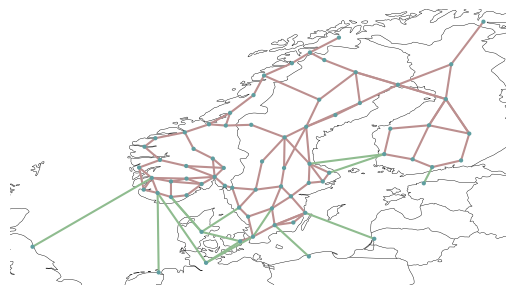

In [18]:
n.plot()
n.links

In [19]:
loads_df, gens_df, ac_flows_df, dc_flows_df = fetch_entsoe_data(start_date="2023-01-01", timezone="Europe/Oslo")


In [20]:
loads_df.head()


Zone,NO_1,NO_2,NO_3,NO_4,NO_5,FI,SE_1,SE_2,SE_3,SE_4,DK_2
Snapshot,,,,,,,,,,,
2023-01-01 00:00:00,4444.0,4182.0,3346.0,2478.0,2009.0,9002.0,1339.0,1417.0,8955.0,2061.0,1282.0
2023-01-01 01:00:00,4423.0,4186.0,3418.0,2483.0,2036.0,8809.0,1346.0,1288.0,8943.0,2018.0,1266.0
2023-01-01 02:00:00,4415.0,4155.0,3483.0,2422.0,2046.0,8632.0,1445.0,1485.0,8929.0,1943.0,1215.0
2023-01-01 03:00:00,4379.0,4168.0,3412.0,2445.0,2039.0,8587.0,1417.0,1624.0,8887.0,1891.0,1166.0
2023-01-01 04:00:00,4349.0,4209.0,3373.0,2439.0,2037.0,8628.0,1427.0,1760.0,8859.0,1844.0,1121.0


In [21]:
"""# aggregate generation to hour × zone
zone_hourly = gens_df.groupby(level="Zone", axis=1).sum() \
                    .reindex(n.snapshots) \
                    .fillna(0.0) 

# quick checks
print(zone_hourly)           # first hours
print(zone_hourly.sum(axis=0))     # total energy per zone (sum over hours)
print(zone_hourly.sum(axis=1))  # total production across all zones per hour"""

'# aggregate generation to hour × zone\nzone_hourly = gens_df.groupby(level="Zone", axis=1).sum()                     .reindex(n.snapshots)                     .fillna(0.0) \n\n# quick checks\nprint(zone_hourly)           # first hours\nprint(zone_hourly.sum(axis=0))     # total energy per zone (sum over hours)\nprint(zone_hourly.sum(axis=1))  # total production across all zones per hour'

In [22]:
"""# ENTSO‑E loads per hour × zone (keep hourly series; no aggregation over time)
if loads_df is None or loads_df.empty:
    zone_load_hourly = pd.DataFrame(index=n.snapshots)
else:
    if isinstance(loads_df.columns, pd.MultiIndex) and "Zone" in loads_df.columns.names:
        zone_load_hourly = loads_df.groupby(level="Zone", axis=1).sum()  # columns -> zones, rows -> hours
    else:
        zone_load_hourly = loads_df.copy()  # assume columns already are zone names
    zone_load_hourly = zone_load_hourly.reindex(n.snapshots).fillna(0.0)

zone_load_hourly = zone_load_hourly.reindex(columns=sorted(zone_load_hourly.columns), fill_value=0.0)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

print("ENTSO‑E loads per hour × zone (first 5 rows):")
print(zone_load_hourly.head().to_string())

print("\nZones (columns) in order:")
print(list(zone_load_hourly.columns))

print("\nTotal load per hour (first 5 rows):")
print(zone_load_hourly.sum(axis=1).head().to_string())"""

'# ENTSO‑E loads per hour × zone (keep hourly series; no aggregation over time)\nif loads_df is None or loads_df.empty:\n    zone_load_hourly = pd.DataFrame(index=n.snapshots)\nelse:\n    if isinstance(loads_df.columns, pd.MultiIndex) and "Zone" in loads_df.columns.names:\n        zone_load_hourly = loads_df.groupby(level="Zone", axis=1).sum()  # columns -> zones, rows -> hours\n    else:\n        zone_load_hourly = loads_df.copy()  # assume columns already are zone names\n    zone_load_hourly = zone_load_hourly.reindex(n.snapshots).fillna(0.0)\n\nzone_load_hourly = zone_load_hourly.reindex(columns=sorted(zone_load_hourly.columns), fill_value=0.0)\n\npd.set_option("display.max_columns", None)\npd.set_option("display.width", None)\n\nprint("ENTSO‑E loads per hour × zone (first 5 rows):")\nprint(zone_load_hourly.head().to_string())\n\nprint("\nZones (columns) in order:")\nprint(list(zone_load_hourly.columns))\n\nprint("\nTotal load per hour (first 5 rows):")\nprint(zone_load_hourly.sum(a

In [23]:
"""gen_totals = zone_hourly.sum(axis=1)            # equivalent to zone_hourly.sum()
load_totals = zone_load_hourly.sum(axis=1)     # equivalent to zone_load_hourly.sum()

diff = gen_totals - load_totals
diff"""

'gen_totals = zone_hourly.sum(axis=1)            # equivalent to zone_hourly.sum()\nload_totals = zone_load_hourly.sum(axis=1)     # equivalent to zone_load_hourly.sum()\n\ndiff = gen_totals - load_totals\ndiff'

In [24]:
dc_contr = dc_flows_df.sum(axis=1)

In [25]:
#diff = gen_totals - load_totals + dc_contr
#diff

In [26]:
# Rename specific dc_flows_df columns (edit mapping targets as needed)

import pandas as pd

# show current columns for verification
print("Before:", list(dc_flows_df.columns)[:200])

# if MultiIndex, flatten to simple names first (optional)
dc = dc_flows_df.copy()
if isinstance(dc.columns, pd.MultiIndex):
    dc.columns = ["_".join(map(str, c)).strip() for c in dc.columns]

# hardcoded mapping - replace RHS with the pypsa link names you want
mapping = {
    "DE_LU<->DK_2": "Kontek",
    "DE_LU<->NO_2": "NordLink",
    "DE_LU<->SE_4": "Baltic Cable",
    "DK_1<->NL":    "DK1-NL",        # update to actual link name if different
    "DK_1<->NO_2":  "DK1-NO",        # update if needed
    "EE<->FI":      "Estlink",
    "FI<->SE_3":    "relation/3391954-500-DC",     # update if different
    "GB<->NO_2":    "North Sea Link",
    "LT<->SE_4":    "NordBalt",
    "NL<->NO_2":    "NorNed",
    "PL<->SE_4":    "SwePol Link",
}

# perform rename (only affects keys present)
dc = dc.rename(columns=mapping)

# if original was MultiIndex and you need to restore a MultiIndex structure,
# handle that after renaming (not shown here).

# assign back (or keep dc separate)
dc_flows_df = dc

print("After:", list(dc_flows_df.columns)[:200])



Before: ['DE_LU<->DK_2', 'DE_LU<->NO_2', 'DE_LU<->SE_4', 'DK_1<->NL', 'DK_1<->NO_2', 'EE<->FI', 'FI<->SE_3', 'GB<->NO_2', 'LT<->SE_4', 'NL<->NO_2', 'PL<->SE_4']
After: ['Kontek', 'NordLink', 'Baltic Cable', 'DK1-NL', 'DK1-NO', 'Estlink', 'relation/3391954-500-DC', 'North Sea Link', 'NordBalt', 'NorNed', 'SwePol Link']


In [27]:
# Validate input data
if dc_flows_df is None or getattr(dc_flows_df, "empty", True):
    raise RuntimeError("dc_flows_df is empty — check fetch_entsoe_data or API results")

# Copy + flatten MultiIndex columns if needed
flows = dc_flows_df.copy()
if isinstance(flows.columns, pd.MultiIndex):
    flows.columns = ["_".join(map(str, c)).strip() for c in flows.columns]

# Align timestamps to network snapshots
flows = flows.reindex(index=n.snapshots).fillna(0.0)

# Optional: mapping to match PyPSA link names
mapping = {}  # {"ENTSO_NSL": "North Sea Link", ...}
if mapping:
    flows = flows.rename(columns=mapping)

# Only keep columns that match existing PyPSA link names
common_links = [c for c in flows.columns if c in n.links.index]
if not common_links:
    raise RuntimeError("No matching link names between ENTSO flows and n.links. Check mapping.")

flows = flows[common_links]

# Ensure n.links_t exists and is properly indexed
if not hasattr(n, "links_t") or not isinstance(n.links_t, pd.DataFrame):
    n.links_t = pd.DataFrame(index=n.snapshots)
    
else:
    n.links_t = n.links_t.reindex(index=n.snapshots)

# Assign p_set for matched links (do not overwrite full dataframe)
for link in common_links:
    n.links_t[("p_set", link)] = flows[link]

print("Successfully assigned p_set to links:", common_links)

# Allow bidirectional flow
n.links.loc[common_links, "p_min_pu"] = -1.0
n.links.loc[common_links, "p_max_pu"] =  1.0

print("p_set assignment complete. Ready for power flow when you choose to run it.")


Successfully assigned p_set to links: ['Kontek', 'NordLink', 'Baltic Cable', 'Estlink', 'relation/3391954-500-DC', 'North Sea Link', 'NordBalt', 'NorNed', 'SwePol Link']
p_set assignment complete. Ready for power flow when you choose to run it.


In [28]:
n.links_t

,"(p_set, Kontek)","(p_set, NordLink)","(p_set, Baltic Cable)","(p_set, Estlink)","(p_set, relation/3391954-500-DC)","(p_set, North Sea Link)","(p_set, NordBalt)","(p_set, NorNed)","(p_set, SwePol Link)"
snapshot,,,,,,,,,
2023-01-01 00:00:00,273.4800,1272.9050,468.79,-812.750,187.65,-627.87,-525.83,649.0900,197.88
2023-01-01 01:00:00,164.1175,1288.9900,506.32,-1005.550,176.82,-178.78,-326.18,649.0900,6.69
2023-01-01 02:00:00,171.0300,1298.0250,506.32,-1013.450,187.49,270.90,-285.48,649.0900,0.00
2023-01-01 03:00:00,306.4950,1298.7775,506.46,-1015.300,187.70,713.15,-521.35,649.0900,0.00
2023-01-01 04:00:00,157.1400,1308.3600,505.98,-1006.700,187.54,1002.64,-406.59,649.0900,0.00
2023-01-01 05:00:00,293.2100,1319.4875,506.13,-1000.650,106.78,1013.98,-662.71,649.0900,0.00
2023-01-01 06:00:00,234.9800,1373.9975,505.98,-1012.200,181.57,1013.99,-611.06,649.0900,0.00
2023-01-01 07:00:00,245.1050,1393.8425,505.85,-794.985,183.81,1013.99,-472.82,649.0900,0.00
2023-01-01 08:00:00,402.4475,1375.0800,506.34,-705.295,183.49,993.83,-462.60,649.0900,0.00


In [29]:
"""def map_and_assign_dc_flows(dc_flows_df, n, manual_mapping=None, verbose=True):
    
    Rename columns in dc_flows_df to match n.links.index and assign into n.links_t.p0.
    Returns the mapping dict and list of unmapped columns.
    
    import re
    manual_mapping = manual_mapping or {}
    links = n.links.copy()
    link_index = links.index.astype(str).tolist()
    mapping = {}

    def find_by_zone_pair(a, b):
        a, b = a.strip(), b.strip()
        # try to match by bus0/bus1 containing zone code or exact bus name
        cond = (
            (links.bus0.astype(str).str.contains(re.escape(a), case=False, na=False) &
             links.bus1.astype(str).str.contains(re.escape(b), case=False, na=False))
            |
            (links.bus0.astype(str).str.contains(re.escape(b), case=False, na=False) &
             links.bus1.astype(str).str.contains(re.escape(a), case=False, na=False))
        )
        cand = links.index[cond].tolist()
        return cand

    for col in dc_flows_df.columns:
        col_s = str(col)
        # exact match first
        if col_s in link_index:
            mapping[col_s] = col_s
            continue
        # manual override
        if col_s in manual_mapping:
            mapping[col_s] = manual_mapping[col_s]
            continue
        # parse typical "A<->B" style
        if "<->" in col_s:
            A, B = map(str.strip, col_s.split("<->", 1))
            cand = find_by_zone_pair(A, B)
            if len(cand) == 1:
                mapping[col_s] = cand[0]
                continue
        # also try splitting on other separators like '-' or ' <-> '
        m = re.match(r"^(.+?)[\s\-_<>]+(?:<->)?[\s\-_<>]+(.+)$", col_s)
        if m:
            A, B = m.group(1).strip(), m.group(2).strip()
            cand = find_by_zone_pair(A, B)
            if len(cand) == 1:
                mapping[col_s] = cand[0]
                continue
        # fallback: try to find any link whose tag/name contains one of the two tokens
        tokens = re.split(r"[<>\-_/ ]+", col_s)
        tokens = [t for t in tokens if t]
        found = None
        for link in link_index:
            if all(any(tok.lower() in str(links.at[link, c]).lower() for c in ("bus0","bus1")) for tok in tokens[:2]):
                found = link
                break
        if found:
            mapping[col_s] = found
        # otherwise leave unmapped

    # Report unmapped
    mapped_cols = set(mapping.keys())
    unmapped = [c for c in dc_flows_df.columns if str(c) not in mapped_cols]
    if verbose:
        print(f"Mapped {len(mapping)} ENTSO cols -> PyPSA links.")
        if unmapped:
            print("Unmapped ENTSO cols (need manual mapping):", unmapped)

    # Apply mapping (only rename keys that exist)
    renamed = dc_flows_df.rename(columns=mapping)
    # Keep only columns that exist in the network links
    common = [c for c in renamed.columns if c in n.links.index]
    flows = renamed[common].reindex(index=n.snapshots).fillna(0.0)

    # Build MultiIndex for links_t (p0 = positive from bus0->bus1)
    if not flows.empty:
        n.links_t = pd.concat({"p0": flows}, axis=1)
        print(f"Assigned n.links_t.p0 for {len(flows.columns)} links.")
    else:
        n.links_t = pd.DataFrame(index=n.snapshots)
        print("No DC flows assigned (flows empty after mapping).")

    return mapping, unmapped

# Example usage (adjust manual_mapping if some columns must be mapped explicitly):
manual_map = {
     "DK1-NO": "relation/3391931-350-DC",
     
    # add entries here if auto-matching fails
}
mapping, unmapped = map_and_assign_dc_flows(dc_flows_df, n, manual_mapping=manual_map)"""

<>:43: SyntaxWarning:

invalid escape sequence '\s'

<>:43: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\aleks\AppData\Local\Temp\ipykernel_38836\48571872.py:43: SyntaxWarning:

invalid escape sequence '\s'



'def map_and_assign_dc_flows(dc_flows_df, n, manual_mapping=None, verbose=True):\n\n    Rename columns in dc_flows_df to match n.links.index and assign into n.links_t.p0.\n    Returns the mapping dict and list of unmapped columns.\n\n    import re\n    manual_mapping = manual_mapping or {}\n    links = n.links.copy()\n    link_index = links.index.astype(str).tolist()\n    mapping = {}\n\n    def find_by_zone_pair(a, b):\n        a, b = a.strip(), b.strip()\n        # try to match by bus0/bus1 containing zone code or exact bus name\n        cond = (\n            (links.bus0.astype(str).str.contains(re.escape(a), case=False, na=False) &\n             links.bus1.astype(str).str.contains(re.escape(b), case=False, na=False))\n            |\n            (links.bus0.astype(str).str.contains(re.escape(b), case=False, na=False) &\n             links.bus1.astype(str).str.contains(re.escape(a), case=False, na=False))\n        )\n        cand = links.index[cond].tolist()\n        return cand\n\n  

In [30]:
n.links_t

,"(p_set, Kontek)","(p_set, NordLink)","(p_set, Baltic Cable)","(p_set, Estlink)","(p_set, relation/3391954-500-DC)","(p_set, North Sea Link)","(p_set, NordBalt)","(p_set, NorNed)","(p_set, SwePol Link)"
snapshot,,,,,,,,,
2023-01-01 00:00:00,273.4800,1272.9050,468.79,-812.750,187.65,-627.87,-525.83,649.0900,197.88
2023-01-01 01:00:00,164.1175,1288.9900,506.32,-1005.550,176.82,-178.78,-326.18,649.0900,6.69
2023-01-01 02:00:00,171.0300,1298.0250,506.32,-1013.450,187.49,270.90,-285.48,649.0900,0.00
2023-01-01 03:00:00,306.4950,1298.7775,506.46,-1015.300,187.70,713.15,-521.35,649.0900,0.00
2023-01-01 04:00:00,157.1400,1308.3600,505.98,-1006.700,187.54,1002.64,-406.59,649.0900,0.00
2023-01-01 05:00:00,293.2100,1319.4875,506.13,-1000.650,106.78,1013.98,-662.71,649.0900,0.00
2023-01-01 06:00:00,234.9800,1373.9975,505.98,-1012.200,181.57,1013.99,-611.06,649.0900,0.00
2023-01-01 07:00:00,245.1050,1393.8425,505.85,-794.985,183.81,1013.99,-472.82,649.0900,0.00
2023-01-01 08:00:00,402.4475,1375.0800,506.34,-705.295,183.49,993.83,-462.60,649.0900,0.00


In [31]:
n.pf()

KeyError: 'p0'